In [1]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [2]:
def get_datetime(time_stamp):
    date = datetime.datetime.strptime(time_stamp,'%Y-%m-%d %H:%M:%S')
    weekday = date.weekday()
    hour = date.hour + date.minute/60
    return weekday,hour

def prepare_data():
    with open('TiktokData.json','r') as json_file:
        json_list = list(json_file)
    json_file.close()
    
    video_list = []
    video_set = set()
    for json_str in json_list:
        video = json.loads(json_str)
        videoID = video['videoId']
        if videoID not in video_set:
            video_list.append(video)
            video_set.add(videoID)
            
    followers = np.array([video['followerCount'] for video in video_list])
    likes = np.array([video['likes'] for video in video_list])
    time_stamps = np.array([get_datetime(video['createDate']) for video in video_list])
    n_samples = len(video_list)
    
    hashtags = []
    all_hashtags = []
    for video in video_list:
        hashtags.append(' '.join(video['hashtags']))
        all_hashtags += video['hashtags']
    
    for i in range(n_samples):
        for tag in hashtags[i].split():
            if all_hashtags.count(tag) < 2:
                hashtags[i] = hashtags[i].replace(tag,'')
    
    countvec = CountVectorizer(strip_accents='ascii',
                           ngram_range = (1,1))
    count_data = countvec.fit_transform(hashtags).toarray()
    
    followers = np.log10(followers)
    features = np.c_[followers,time_stamps,count_data]
    df = pd.DataFrame(features)
    X = features
    ratio = likes/(10**followers)
    y = np.where(ratio > 10,1,0)
    y = np.where(np.logical_and(likes>1e4,ratio>10),1,0)
    return X,y

def choose_k(X,y,plot_results=True):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state=42)
    
    n_samples = len(y)
    k_guess = int(np.sqrt(n_samples))
    print(k_guess)
    kmax = k_guess+20
    test_scores = []
    train_scores = []
    for k in range(1,kmax,2):
        KNN = KNeighborsClassifier(n_neighbors=k)
        KNN = KNN.fit(X_train,y_train)
        y_pred = KNN.predict(X_test)
        test_score = accuracy_score(y_test,y_pred)
        train_score = accuracy_score(y_train,KNN.predict(X_train))
        test_scores.append(test_score)
        train_scores.append(train_score)
    
    if plot_results:
        krange = range(1,kmax,2)
        plt.plot(krange,test_scores,'--',label='Test Accuracy')
        plt.plot(krange,train_scores,label='Train Accuracy')
        plt.title('k Optimization')
        plt.xlabel('k value')
        plt.ylabel('Accuracy')
        plt.legend()
        
    return 

def evaluate_prediction(X,y,k):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state=42)
    
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN = KNN.fit(X_train,y_train)
    y_pred = KNN.predict(X_test)
    test_score = accuracy_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    conf = confusion_matrix(y_test,y_pred)
    
    return KNN,acc,report,conf

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
def choose_k_silhouette(X, y, plot_results=True):
    """
    Determines the optimal number of neighbors (k) for the K-Nearest Neighbors (KNN) classifier
    based on the silhouette score of predictions on training and testing data sets.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    n_samples = len(y)
    k_guess = int(np.sqrt(n_samples))
    kmax = k_guess + 20
    silhouette_scores = []

    for k in range(1, kmax, 2):
        KNN = KNeighborsClassifier(n_neighbors=k)
        KNN.fit(X_train, y_train)
        labels = KNN.predict(X_test)
        # Calculate the silhouette score, ensure there are at least 2 clusters to calculate
        if len(set(labels)) > 1:
            score = silhouette_score(X_test, labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Not enough clusters to evaluate silhouette score

    if plot_results:
        krange = list(range(1, kmax, 2))
        max_score = max(silhouette_scores)
        max_k = krange[silhouette_scores.index(max_score)]

        plt.figure(figsize=(10, 5))
        plt.plot(krange, silhouette_scores, marker='o', label='Silhouette Score')
        plt.scatter(max_k, max_score, color='red', s=100, label=f'Max Score {max_score:.2f} at k={max_k}')
        plt.title('KNN Silhouette Score Optimization')
        plt.xlabel('k value')
        plt.ylabel('Silhouette Score')
        plt.xticks(krange)
        plt.grid(True)
        plt.legend()
        plt.show()


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,5.349666,11.983333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.790707,23.916667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.086360,15.783333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.415808,15.400000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.414973,12.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,6.278754,10.250000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1863,6.255273,0.933333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1864,5.971601,11.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1865,5.203305,13.233333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


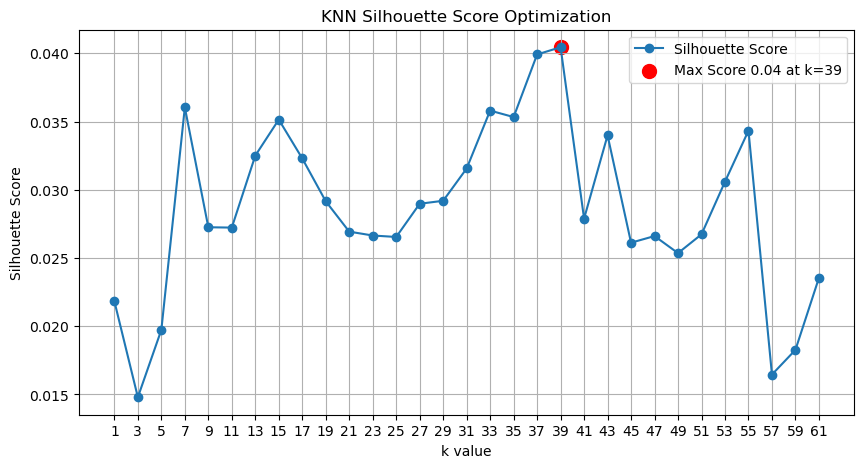

In [15]:
X,y = prepare_data()
X_new = SelectKBest(f_classif,k=23).fit_transform(X,y)
# X_new = X_new[:,:2]
df = pd.DataFrame(X_new)
display(df)
choose_k_silhouette(X_new,y)

Accuracy Score: 0.844

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       363
           1       0.68      0.56      0.61       104

    accuracy                           0.84       467
   macro avg       0.78      0.74      0.76       467
weighted avg       0.84      0.84      0.84       467



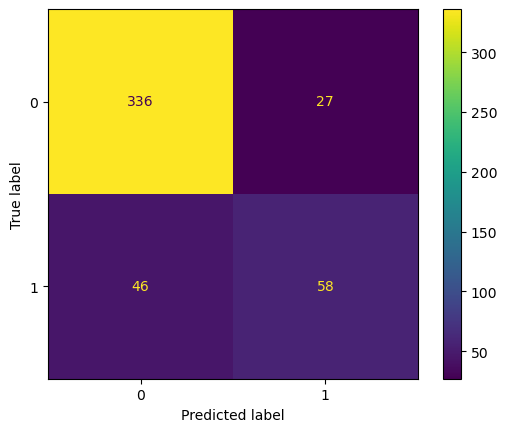

In [6]:
KNN,acc,report,conf = evaluate_prediction(X_new,y,19)
print('Accuracy Score: {}\n'.format(round(acc,3)))
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                              display_labels = KNN.classes_)
disp.plot()
plt.show()

0.8372591006423983
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       363
           1       0.72      0.44      0.55       104

    accuracy                           0.84       467
   macro avg       0.79      0.70      0.72       467
weighted avg       0.83      0.84      0.82       467

[[345  18]
 [ 58  46]]


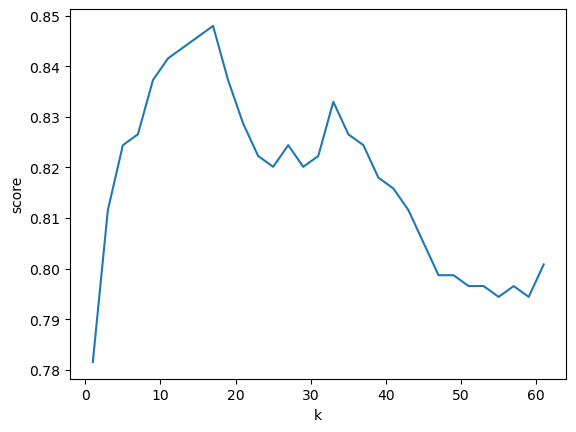

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state=42)


n_samples = len(y)
kmid = int(np.sqrt(n_samples))

scores = []
kmin = 1
kmax = kmid+20
for k in range(kmin,kmax,2):
    #Train KNN
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN = KNN.fit(X_train,y_train)
    
    #Test KNN
    scores.append(KNN.score(X_test,y_test))

plt.plot(range(kmin,kmax,2),scores)
plt.ylabel('score')
plt.xlabel('k')

KNN = KNeighborsClassifier(n_neighbors=19)
KNN = KNN.fit(X_train,y_train)

y_pred = KNN.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8008565310492506
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       363
           1       0.55      0.55      0.55       104

    accuracy                           0.80       467
   macro avg       0.71      0.71      0.71       467
weighted avg       0.80      0.80      0.80       467



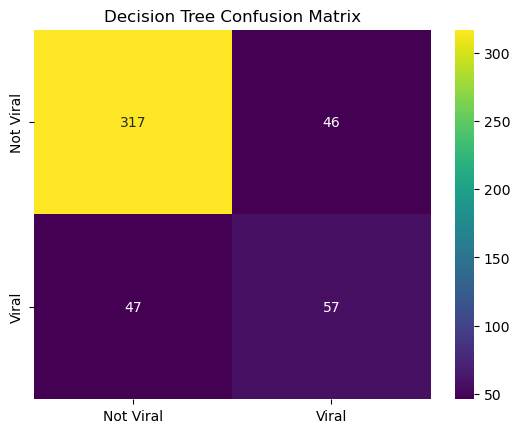

[0.65743067 0.27905385 0.00191265 0.01174372 0.01304601 0.02570694
 0.         0.00327741 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00204244 0.00106882 0.         0.         0.0047175 ]
0.06351548294786447


In [22]:
from sklearn import tree
from sklearn import metrics
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X_new,y,
                                                    random_state=42,
                                                    test_size = 0.25)
 

# Initialize decision tree classifier
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  random_state=42)
clf.fit(X_train,y_train) # Fit model to train data
y_pred = clf.predict(X_test) # Use model to predict test data
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
conf = confusion_matrix(y_test,y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf,
#                               display_labels = clf.classes_)

fig,ax = plt.subplots()
sns.heatmap(conf,annot=True,fmt='g',ax=ax,cmap='viridis')
ax.xaxis.set_ticklabels(['Not Viral', 'Viral'])
ax.yaxis.set_ticklabels(['Not Viral', 'Viral'])
ax.set_title('Decision Tree Confusion Matrix')
plt.show()

print(clf.feature_importances_)

print(sum(clf.feature_importances_[2:]))

# disp.plot()
plt.show()

0.8522483940042827
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       363
           1       0.68      0.62      0.65       104

    accuracy                           0.85       467
   macro avg       0.79      0.77      0.78       467
weighted avg       0.85      0.85      0.85       467



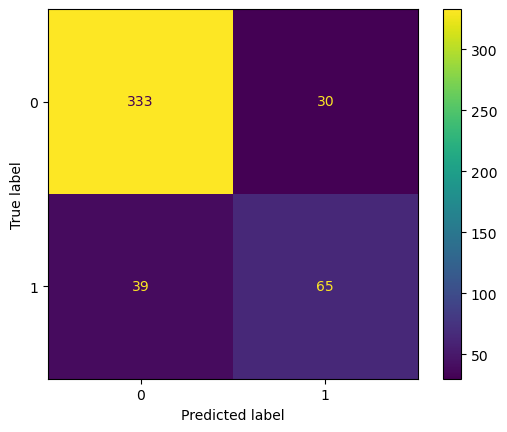

In [9]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X_new,y,
                                                    random_state=42)

clf = MLPClassifier(max_iter=500,random_state=42)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test) # Use model to predict test data
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
conf = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                              display_labels = clf.classes_)

disp.plot()
plt.show()

0.8522483940042827
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       363
           1       0.68      0.62      0.65       104

    accuracy                           0.85       467
   macro avg       0.79      0.77      0.78       467
weighted avg       0.85      0.85      0.85       467



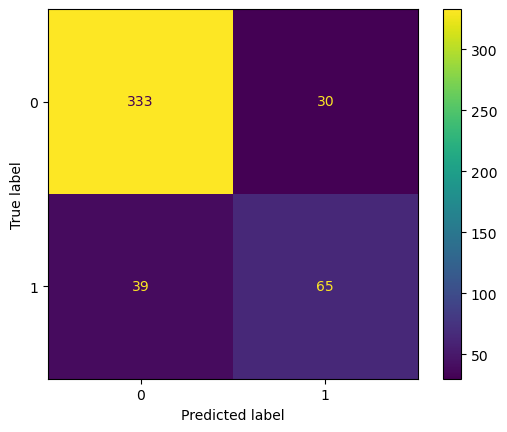

In [10]:
from sklearn.model_selection import GridSearchCV


clf = MLPClassifier(max_iter=500,random_state=42)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test) # Use model to predict test data
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
conf = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                              display_labels = clf.classes_)

disp.plot()
plt.show()